# Project Title
### Data Engineering Capstone Project

#### Project Summary
### Overview
#### The purpose of this project is to provide a deep dive into US immigration, primiarily focusing on the type of visas being issued and the profiles associated. The scope of this project is limited to the data sources listed below with data being aggregated across numerous features such as visatype, gender, port_of_entry, nationality and month.


The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
import pandas as pd
import configparser
from datetime import datetime
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col , monotonically_increasing_id
from pyspark.sql.functions import year, month, dayofmonth, hour, weekofyear, date_format
from pyspark.sql import types as t
from pyspark.sql import SparkSession
import re
import io

In [2]:
#def create_spark_session():
 #   spark = SparkSession \
  #      .builder \
   #     .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0","saurfang:spark-sas7bdat:2.0.0-s_2.11") \
    #    .enableHiveSupport().getOrCreate()
    #return spark

In [3]:
import configparser
config = configparser.ConfigParser()
config.read('dls.cfg')

os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['AWS_SECRET_ACCESS_KEY']

In [4]:
import boto3
from botocore.exceptions import NoCredentialsError

s3 = boto3.client('s3')

bucket_name  = 'udend-capstone-immig'

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
 config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11,org.apache.hadoop:hadoop-aws:2.7.5")\
.enableHiveSupport().getOrCreate()

df_spark =spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')
    
#df_spark =spark.read.format('com.github.saurfang.sas.spark').load('I94_SAS_Labels_Descriptions.SAS')
#df_spark =spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

### Step 1: Scope the Project and Gather Data

#### Scope 
Scope
In this project, we will build I94 immigration star schema model which contrain 1 fact (immigration Fact) and 6 dimesnionn table (Dim_Visa,Dim_State,Dim_Airport,Dim_i94mode,Dim_Country,Dim_Date) which helps to anaylyze and aggregate the data various data aspects.

#### Describe and Gather Data 
####Data Description & Sources
I94 Immigration Data: This data comes from the US National Tourism and Trade Office found here. Each report contains international visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries).
World Temperature Data: This dataset came from Kaggle found <a href="https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data"> here </a>

U.S. City Demographic Data: This dataset contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000. Dataset comes from OpenSoft found here.

Airport Code Table: This is a simple table of airport codes and corresponding cities. The airport codes may refer to either IATA airport code, a three-letter code which is used in passenger reservation, ticketing and baggage-handling systems, or the ICAO airport code which is a four letter code used by ATC systems and for airports that do not have an IATA airport code (from wikipedia). It comes from here.

### The definition of the fields is included in the file I94_SAS_Labels_Descriptions.SAS 
#### Following code parse the above file and creates various data dictionnary files which will be used to build the Dimension tables.

In [6]:
with open("I94_SAS_Labels_Descriptions.SAS", 'r') as file_handle:
    # read file content into list
    #lines = file_handle.readlines()
    file=file_handle.read()
    #headers=next(lines)
sas_dict={}
temp_data=[]

In [7]:
for line in file.split("\n"):
        line = re.sub(r"\s+", " ", line)
        if "/*" in line and "-" in line:
            k, v = [i.strip(" ") for i in line.split("*")[1]
                                              .split("-", 1)]
            k = k.replace(' & ', '_').lower()
            sas_dict[k] = {'description': v}
        elif '=' in line and ';' not in line:
            temp_data.append([i.strip(' ').strip("'").title()
                              for i in line.split('=')])
        elif len(temp_data) > 0:
            sas_dict[k]['data'] = temp_data
            temp_data = []

sas_dict['i94cit_i94res']['df'] = pd.DataFrame(
        sas_dict['i94cit_i94res']['data'], columns=['code', 'country'])

tempdf = pd.DataFrame(sas_dict['i94port']['data'],
                          columns=['code', 'port_of_entry'])
tempdf['code'] = tempdf['code'].str.upper()
tempdf[['city', 'state_or_country']] = tempdf['port_of_entry'
                                                  ].str.rsplit(',', 1,
                                                               expand=True)
sas_dict['i94port']['df'] = tempdf

sas_dict['i94mode']['df'] = pd.DataFrame(
        sas_dict['i94mode']['data'], columns=['code', 'transportation'])

tempdf = pd.DataFrame(sas_dict['i94addr']['data'],
                          columns=['code', 'state'])
tempdf['code'] = tempdf['code'].str.upper()
sas_dict['i94addr']['df'] = tempdf

sas_dict['i94visa']['df'] = pd.DataFrame(
    
    sas_dict['i94visa']['data'], columns=['code', 'reason_for_travel'])

for table in sas_dict.keys():
    if 'df' in sas_dict[table].keys():
        with io.open(f"{table}.csv", "w" ) as f:
           sas_dict[table]['df'].to_csv(f, index=False)
                

In [6]:
# Read in the data from csv files to create data reference(dictionary) tables
#spark=create_spark_session()
df_countryCodes=spark.read.format("csv").option("header", "true").load("i94cit_i94res.csv")
df_i94_mode=spark.read.format("csv").option("header", "true").load("i94mode.csv")
df_i94_visa=spark.read.format("csv").option("header", "true").load("i94visa.csv")
df_i94_add=spark.read.format("csv").option("header", "true").load("i94addr.csv")
df_i94_port=spark.read.format("csv").option("header", "true").load("i94port.csv")
#df_us_demographics=spark.read.option(Map "delimiter", ";" "header", "true").csv("us-cities-demographics.csv")
df_us_demographics=spark.read.format("csv").options(header="true",delimiter=";").load("us-cities-demographics.csv")

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### In this following section, we will be exploring data sets provided by UDactiy
and give a summarized idea on the reasons we took into consideration when deciding what data to use.

Immigration Data , 
Airport data  , 
Visa Types  , 
I94port ,
Us-demographics data 

#### Cleaning Steps
Document steps necessary to clean the data

### Airport data
##### Since airports are the point of entry for these immigrants, we will include airport information in our data.
Airport Code Table: This is a simple table of airport codes and corresponding cities. The airport codes may refer to either IATA airport code, a three-letter code which is used in passenger reservation, ticketing and baggage-handling systems, or the ICAO airport code which is a four letter code used by ATC systems and for airports that do not have an IATA airport code (from wikipedia)

In [7]:
# Read data from airport csv file
df_airport = spark.read.format("csv").option("header", "true").load("airport-codes_csv.csv")


In [8]:
#Print Airport data schema
print(" Airport Data Schema...")
df_airport.printSchema()
# Print Airpot sample
print(" Airport Data sample..")
df_airport.head()
df_us_demographics.printSchema()
df_us_demographics
df_us_demographics.show(5)

 Airport Data Schema...
root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)

 Airport Data sample..
root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |--

In [9]:
#Print Country data schema
print(" Country Data Schema...")

df_countryCodes.printSchema()
# Print Country sample
df_countryCodes.head()

#Print Airport data schema
print(" i94 mode Data Schema...")
df_i94_mode.printSchema()
# Print Airpot sample
print(" i94 Data sample..")
df_i94_mode.head()



 Country Data Schema...
root
 |-- code: string (nullable = true)
 |-- country: string (nullable = true)

 i94 mode Data Schema...
root
 |-- code: string (nullable = true)
 |-- transportation: string (nullable = true)

 i94 Data sample..


Row(code='1', transportation='Air')

In [10]:
df_airport.createOrReplaceTempView("airport_codes_df")
airport_codes_table=spark.sql(""" SELECT * FROM airport_codes_df """)
print("Sample Airport data....")
#airport_codes_table.show(5)

df_countryCodes.createOrReplaceTempView ("countryCodes_df")
countryCodes=spark.sql (""" SELECT * FROM countryCodes_df""")
print("Sample Country Codes data....")
#countryCodes.show(5)
df_countryCodes.printSchema()

df_i94_mode.createOrReplaceTempView("i94_mode_df")
i94_mode=spark.sql("""SELECT * FROM i94_mode_df """)

print("Sample 94 mode data....")
#i94_mode.show(5)
i94_mode.printSchema()

df_i94_visa.createOrReplaceTempView("i94_visa_df")
i94_visa=spark.sql("""SELECT * FROM i94_visa_df""")
print("print Visa types.....")
#i94_visa.show(5)
i94_visa.printSchema()

df_i94_add.createOrReplaceTempView("i94_add_df")
i94_state=spark.sql ("""SELECT * FROM i94_add_df""")
print (" print i94 state codes data....")
#i94_state.show(5)
i94_state.printSchema()

df_i94_port.createOrReplaceTempView("i94_port_df")
i94_port=spark.sql("""SELECT * FROM  i94_port_df""")
print(" Print port info...")
#i94_port.show(5)
i94_port.printSchema()






Sample Airport data....
Sample Country Codes data....
root
 |-- code: string (nullable = true)
 |-- country: string (nullable = true)

Sample 94 mode data....
root
 |-- code: string (nullable = true)
 |-- transportation: string (nullable = true)

print Visa types.....
root
 |-- code: string (nullable = true)
 |-- reason_for_travel: string (nullable = true)

 print i94 state codes data....
root
 |-- code: string (nullable = true)
 |-- state: string (nullable = true)

 Print port info...
root
 |-- code: string (nullable = true)
 |-- port_of_entry: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state_or_country: string (nullable = true)



In [11]:
us_demographics_df =df_us_demographics.withColumnRenamed("Median Age","Median_Age")\
                  .withColumnRenamed("Male Population","Male_Population")\
                  .withColumnRenamed("Female Population","Female_Population")\
                  .withColumnRenamed("Total Population","Total_Population")\
                  .withColumnRenamed("Number of Veterans","Number_of_Veterans")\
                  .withColumnRenamed("Foreign-born","Foreign_born")\
                  .withColumnRenamed("Average Household Size","Average_Household_Size")\
                  .withColumnRenamed("State Code","State_Code")
us_demographics_df.printSchema()


root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median_Age: string (nullable = true)
 |-- Male_Population: string (nullable = true)
 |-- Female_Population: string (nullable = true)
 |-- Total_Population: string (nullable = true)
 |-- Number_of_Veterans: string (nullable = true)
 |-- Foreign_born: string (nullable = true)
 |-- Average_Household_Size: string (nullable = true)
 |-- State_Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)



### Immigration Data

##### U.S. immigration officers issued the I-94 Form (Arrival/Departure Record) to foreign visitors (e.g., business visitors, tourists and foreign students) who lawfully entered the United States. The I-94 was a small white paper form that a foreign visitor received from cabin crews on arrival flights and from U.S. Customs and Border Protection at the time of entry into the United States. It listed the traveler's immigration category, port of entry, data of entry into the United States, status expiration date and had a unique 11-digit identifying number assigned to it. Its purpose was to record the traveler's lawful admission to the United States.

##### This is the main dataset and there is a file for each month of the year of 2016 available in the directory ../../data/18-83510-I94-Data-2016/ in the SAS binary database storage format sas7bdat. Combined, the 12 datasets have got more than 40 million rows (40.790.529) and 28 columns. For most of the work we used only the month of April of 2016 which has more than three million records (3.096.313).

In [12]:
df_immig =spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

In [13]:
df_immig.printSchema()
df_immig.createOrReplaceTempView("Immigration_df")

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [14]:
Immigration_df=spark.sql(""" SELECT * FROM Immigration_df """)

Immigration_df.show(5)                     

+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|        admnum|fltno|visatype|
+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|  6.0|2016.0|   4.0| 692.0| 692.0|    XXX|20573.0|   null|   null|   null|  37.0|    2.0|  1.0|    null|    null| null|      T|   null|      U|   null| 1979.0|10282016|  null|  null|   null| 1.897628485E9| null|      B2|
|  7.0|2016.0|   4.0| 254.0| 276.0|    ATL|20551.0|    1.0|     AL|   null|  25.0|    3.0|  1.0|20130811|     SE

#### Cleaning Steps
Document steps necessary to clean the data
#### Remove null rows from the datasets
#### Remove invalid columns values from the datasets

In [15]:
# Performing cleaning tasks here
#Check airport table for any nulls and drop the rows 
from pyspark.sql.functions import isnan, when, count, col

airport_codes_table.select([count(when(isnan(c), c)).alias(c) for c in airport_codes_table.columns]).show()

#Drop anyn null rows
airport_codes_table= airport_codes_table.na.drop()
airport_codes_table.show(5)
# Check the airport country before we use the data in our data model 
airport_codes_table.groupby('iso_country').count().show()

+-----+----+----+------------+---------+-----------+----------+------------+--------+---------+----------+-----------+
|ident|type|name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|coordinates|
+-----+----+----+------------+---------+-----------+----------+------------+--------+---------+----------+-----------+
|    0|   0|   0|           0|        0|          0|         0|           0|       0|        0|         0|          0|
+-----+----+----+------------+---------+-----------+----------+------------+--------+---------+----------+-----------+

+-----+-------------+--------------------+------------+---------+-----------+----------+-------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region| municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+--------

#### since immigration data we are working is USA only , remove non US airport codes from airport dataset thus reduce the data size


In [16]:
#since immigration data we are working is USA only , remove non US airport codes from airport dataset thus reduce the data size

airport_codes_table=airport_codes_table.filter(airport_codes_table.iso_country=='US')
airport_codes_table.show(5)

+-----+-------------+--------------------+------------+---------+-----------+----------+-------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region| municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+-------------+--------+---------+----------+--------------------+
| 07FA|small_airport|Ocean Reef Club A...|           8|       NA|         US|     US-FL|    Key Largo|    07FA|      OCA|      07FA|-80.274803161621,...|
| 0CO2|small_airport|Crested Butte Air...|        8980|       NA|         US|     US-CO|Crested Butte|    0CO2|      CSE|      0CO2|-106.928341, 38.8...|
| 0TE7|small_airport|   LBJ Ranch Airport|        1515|       NA|         US|     US-TX| Johnson City|    0TE7|      JCY|      0TE7|-98.6224975585999...|
| 13MA|small_airport|Metropolitan Airport|         418|       NA|         US

In [17]:
# Check diffrent airport types
airport_codes_table.groupby('type').count().show()

+--------------+-----+
|          type|count|
+--------------+-----+
| large_airport|  167|
| seaplane_base|   37|
|      heliport|   19|
|        closed|   18|
|medium_airport|  653|
| small_airport| 1015|
+--------------+-----+



#### filter closed , heliport and seaplace base airport types since no immigration is collected in those places


In [18]:
# filter closed , heliport and seaplace base airport types since no immigration is collected in those places
non_airport=['closed','heliport','seaplane_base']
airport_codes_table=airport_codes_table.filter(~airport_codes_table.type.isin (non_airport))
airport_codes_table.groupby('type').count().show()

+--------------+-----+
|          type|count|
+--------------+-----+
| large_airport|  167|
|medium_airport|  653|
| small_airport| 1015|
+--------------+-----+



In [19]:
# Conert iso_region format to proer state code format

from pyspark.sql.functions import *
#airport_codes_table.show()
airport_codes_table = airport_codes_table.withColumn("iso_region", regexp_replace(airport_codes_table['iso_region'], 'US-', ''))
airport_codes_table.show(5)
#airport_codes_table['state'] = airport_codes_table['iso_region'].split("-", n = 1, expand = True)[1]


+-----+-------------+--------------------+------------+---------+-----------+----------+-------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region| municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+-------------+--------+---------+----------+--------------------+
| 07FA|small_airport|Ocean Reef Club A...|           8|       NA|         US|        FL|    Key Largo|    07FA|      OCA|      07FA|-80.274803161621,...|
| 0CO2|small_airport|Crested Butte Air...|        8980|       NA|         US|        CO|Crested Butte|    0CO2|      CSE|      0CO2|-106.928341, 38.8...|
| 0TE7|small_airport|   LBJ Ranch Airport|        1515|       NA|         US|        TX| Johnson City|    0TE7|      JCY|      0TE7|-98.6224975585999...|
| 13MA|small_airport|Metropolitan Airport|         418|       NA|         US

In [20]:
# split coordinates columsn into Latitude and Longitude  columns

airport_codes_table=airport_codes_table.withColumn("Latitude",split(airport_codes_table['coordinates'],",").getItem(0))
airport_codes_table=airport_codes_table.withColumn("Longitude",split(airport_codes_table['coordinates'],",").getItem(1))
airport_codes_table.show(5)

#Filter airport regions whcih are not in region (state) data set
#airport_df=airport_codes_table.join (i94_state,airport_codes_table.iso_region == i94_state.code,how='left')
#airport_df=airport_df.filter(airport_df['iso_region'].isNull())
#airport_df.show()
airport_codes_table.createOrReplaceTempView("airport_df")
airport_df=spark.sql(""" SELECT a.* FROM airport_df a  JOIN  i94_add_df b on a.iso_region =b.code """)
airport_df.printSchema()

+-----+-------------+--------------------+------------+---------+-----------+----------+-------------+--------+---------+----------+--------------------+------------------+-------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region| municipality|gps_code|iata_code|local_code|         coordinates|          Latitude|          Longitude|
+-----+-------------+--------------------+------------+---------+-----------+----------+-------------+--------+---------+----------+--------------------+------------------+-------------------+
| 07FA|small_airport|Ocean Reef Club A...|           8|       NA|         US|        FL|    Key Largo|    07FA|      OCA|      07FA|-80.274803161621,...|  -80.274803161621|    25.325399398804|
| 0CO2|small_airport|Crested Butte Air...|        8980|       NA|         US|        CO|Crested Butte|    0CO2|      CSE|      0CO2|-106.928341, 38.8...|       -106.928341|          38.851918|
| 0TE7|small_airport|   LBJ Ranch A

#### The dates in the  immigration dataframe are stored in SAS date format, which is a value that represents the number of days between January 1, 1960, and a specified date. 
We convert the dates in the dataframe to a string date format in the pattern YYYY-MM-DD

In [21]:
Immigration_df=spark.sql ("""SELECT *,
CASE WHEN arrdate >= 1.0 THEN date_add(to_date('1960-01-01'), arrdate)  ELSE NULL END  AS arrival_date,
CASE WHEN depdate >= 1.0 THEN date_add(to_date('1960-01-01'), depdate) ELSE NULL END AS departure_date
FROM Immigration_df """)

Immigration_df.show(5)

+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+------------+--------------+
|cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|        admnum|fltno|visatype|arrival_date|departure_date|
+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+------------+--------------+
|  6.0|2016.0|   4.0| 692.0| 692.0|    XXX|20573.0|   null|   null|   null|  37.0|    2.0|  1.0|    null|    null| null|      T|   null|      U|   null| 1979.0|10282016|  null|  null|   null| 1.897628485E9| null|      B2|  2016-04-29|          null|


In [22]:
spark.sql (""" SELECT i94mode , Count(*) From Immigration_df group by i94mode """).show()
#Immigration_df=Immigration_df.where(Immigration_df.i94mode is 'null').show()

+-------+--------+
|i94mode|count(1)|
+-------+--------+
|   null|     239|
|    1.0| 2994505|
|    3.0|   66660|
|    2.0|   26349|
|    9.0|    8560|
+-------+--------+



#### The arrival modes definition as per the dictonary is:

1 = 'Air'
2 = 'Sea'
3 = 'Land'
9 = 'Not reported' 
We will keep only  valid i94 mode set to ensure that our dataset can work with the airports dataset


In [23]:
#Filter invalid  i94 mode values from data set. like null and 9
Immigration_df=Immigration_df.filter(Immigration_df.i94mode.isNotNull())
Immigration_df=Immigration_df.filter(Immigration_df.i94mode != 9.0)
Immigration_df.count()

3087514

In [25]:
#Verify the result set to check it filtered all invalid data from data set
Immigration_df.groupBy(Immigration_df.i94mode).count().show()
#Immigration_df.count()

+-------+-------+
|i94mode|  count|
+-------+-------+
|    1.0|2994505|
|    3.0|  66660|
|    2.0|  26349|
+-------+-------+



In [25]:
# Immigration_df=Immigration_df.withColumn("arrdate",expr("date_add(to_date('1960-01-01'),Immigration_df.arrdate)"))
Immigration_df.printSchema()
#Change column type from double to integer

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [24]:
# Check if any Visa , port values are null.
spark.sql(""" SELECT Count(*) From Immigration_df Where i94visa is null""").show()
spark.sql(""" SELECT Count(*) From Immigration_df Where i94port is null""").show()



+--------+
|count(1)|
+--------+
|       0|
+--------+

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [28]:
# import AWS credentials from config file
import configparser
config = configparser.ConfigParser()
config.read('dls.cfg')

os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['AWS_SECRET_ACCESS_KEY']

#Immigration_df.write.parquet("s3a://udend-capstone-immig/",mode="overwrite")


In [28]:
# Check aws connectivity 
import boto3
from botocore.exceptions import NoCredentialsError

s3 = boto3.client('s3')

bucket_name  = 'udend-capstone-immig'

#### Once data was collected and cleansed we will export the data to S3 bukcket in Parquet format

In [41]:
# write dataframe output to S3 bucket in parquet format

airport_df.write.mode("overwrite").parquet("s3a://udend-capstone-immig/airport_data/")
countryCodes.write.mode("overwrite").parquet("s3a://udend-capstone-immig/countryCodes/")
i94_mode.write.mode("overwrite").parquet("s3a://udend-capstone-immig/i94_mode/")
i94_visa.write.mode("overwrite").parquet("s3a://udend-capstone-immig/i94_visa/")
i94_state.write.mode("overwrite").parquet("s3a://udend-capstone-immig/i94_state/")
i94_port.write.mode("overwrite").parquet("s3a://udend-capstone-immig/i94_port/")
us_demographics_df.write.mode("overwrite").parquet("s3a://udend-capstone-immig/us_demographics/")





In [21]:
Immigration_df.write.mode("overwrite").parquet("s3a://udend-capstone-immig/immig/")

show### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model 

The immigration dataset is the origin of the center of our model. As this represent the facts of what we want to analyse - U.S visitors from the world -, this was transformed to the fact table IMMIGRATION as represented in the schema below. We gave this data most of the focus during our modeling phase. The immigration dataset is also the data source for the DATE dimension table. We extracted all the distinct values of the columns arrdate and depdate and applied various functions to store in the table a number of attributes of a particular date: day, month, year, week of year and day of week.

AIRPORT_Dim table consist of airports data with location and  aitrport type and name details , which is going to help us determine the number visitors gone through each airport with thier port  of entry information

I94MODe_Dim data set consit of mode of the visitors arriving to IS like byt air,land and sea and DIm_VISA data set consist of differnt Visa types information which helps us to find vistors VISA status and thier purpose of visit.

DIM_STATE,DIM_COUNTRY dat sets contains Country and State information, with Immmigration fact join we can analyze origin of the visitors and their nationality.

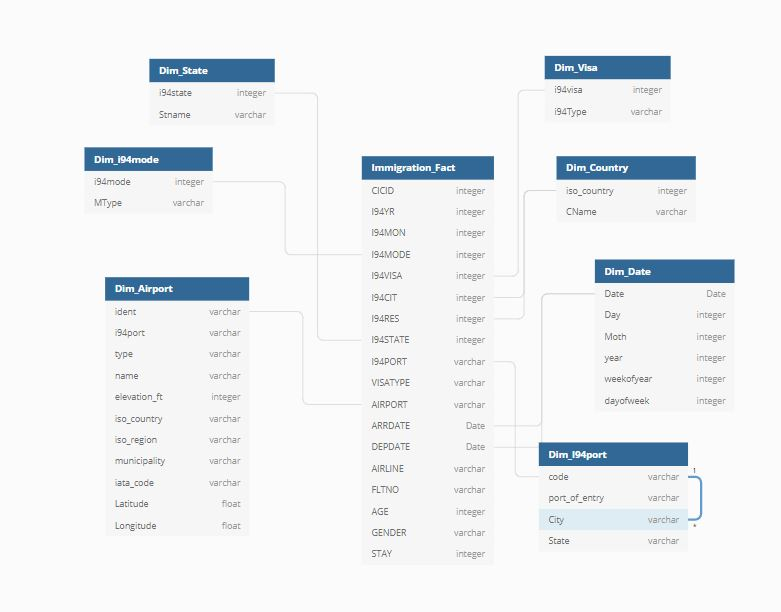

In [17]:
from IPython.display import Image
Image(filename='Capstone_DM.JPG')

and explain why you chose that model

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

### Build the data pipelines to create the data model.

The whole pipeline can be divided into two stages. The first, where we used spark to load, extracted, transform and store the provided datasets into the AWS S3 staging area.
The second stage we take advantage of Apache Airflow to build a DAG to extract data from S3 and load them into tables of the same name in Amazon Redshift. As a final step we check the data counting checking to ensure completeness.

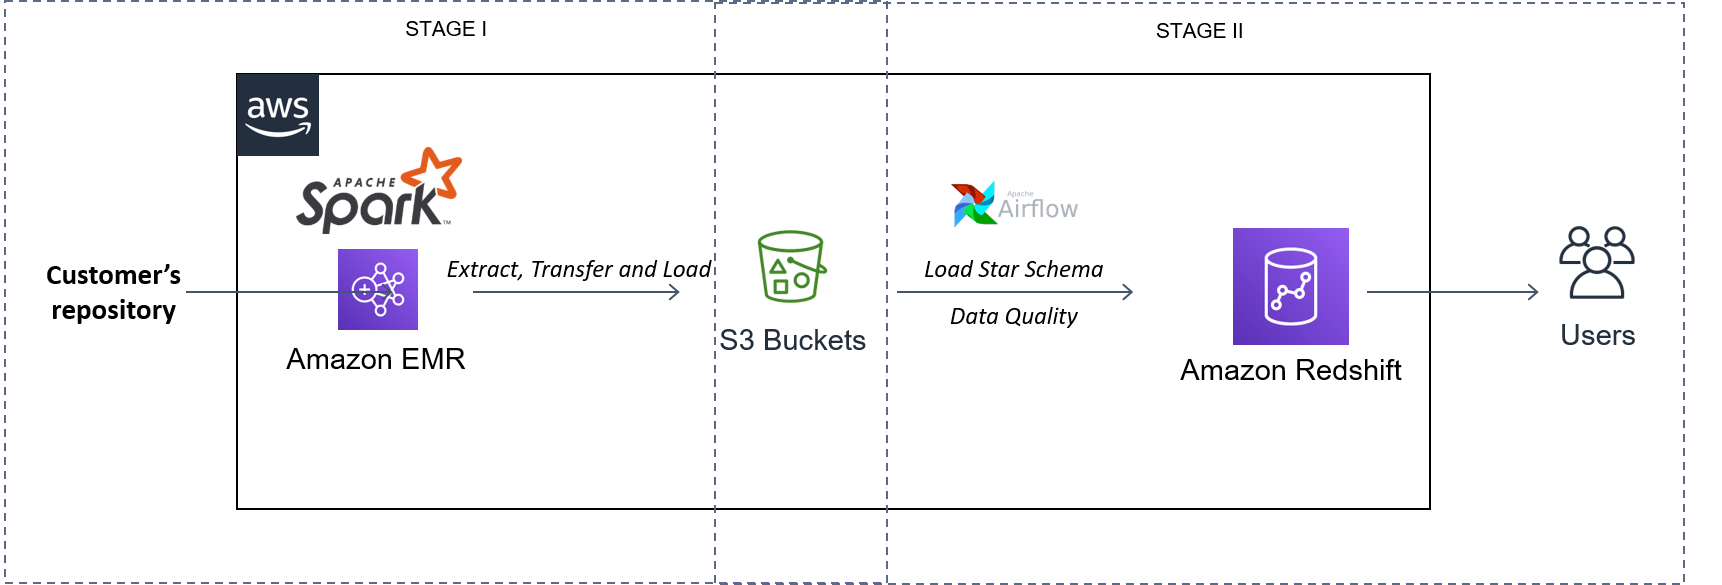

In [15]:
from IPython.display import Image
Image(filename='architecture.jpg')

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

#### Below we show the pipeline of the second stage  developed using Apache Airflow.



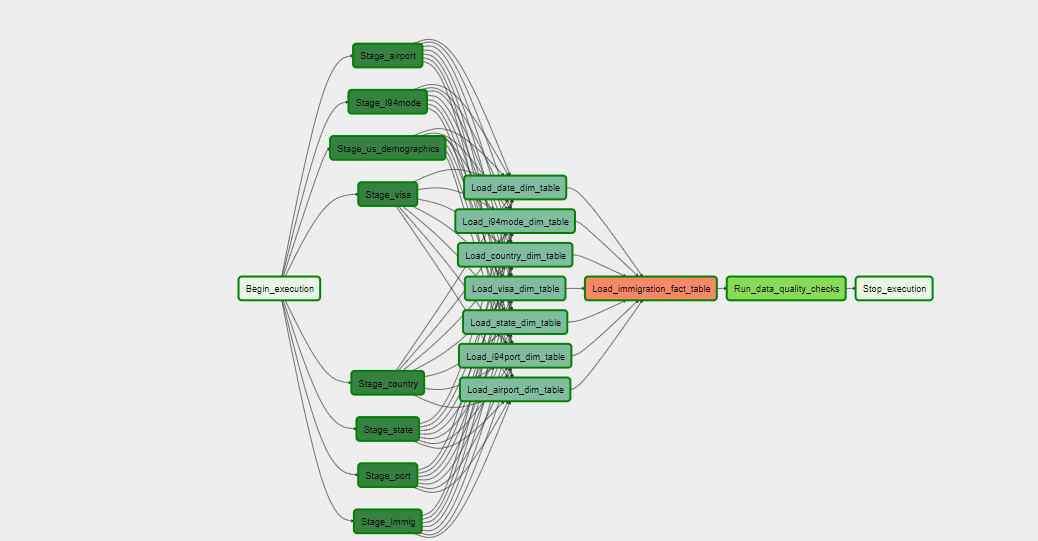

In [14]:
from IPython.display import Image
Image(filename='capstone_af.jpg')

The code to build the Airflow pipeline is located in the folder airflow. There you will find the code of the DAG itself (file udend_cap_dag.py inside folder dags) as well as the two custom operators built for this capstone project in folder plugins/operators: stage_redshift.py ,load_dimension.py,load_fact.py and data_quality.py.

The custom operator StageToRedshiftOperator was designed to load data in parquet format from S3 buckets in AWS and insert the content into a table in AWS Redshift. That operator is customizable to work with different buckets and with different tables by input parameters. Then it is used in our DAG to load to Redshift both fact and dimension tables.

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

we have performed all the data cleansing and quality checks in Pyspark datafram and then exported cleansed data to s3 parquet files
First we load the data into stage tables from s3 parquet files. After all the stages are loaded then we load data into Dimension tables respecitvely 
Dim_Date,Dim_Visa,Dim_Airport,Dim_i94mode,Dim_State,Dim_country and Dim_I94port.
To make sure the data integrity we defined the Pirmay Keys on the tables to  make each dim table represent one unique row.
Immigration_Fact which source data from Immigration_Stg tables contains Foreign Keys from Dim tables and Primary Key defined to maintain referential integrity

Data quality checks include:

.1)Integrity constraints on the relational database (e.g., unique key, data type, etc.)
2)Unit tests for the scripts to ensure they are doing the right thing
3)Source/Count checks to ensure completeness

#### 4.3 Data dictionary 


#### IMMIGRATION_FACT
<html>
    
 <Body>  
<table align="LEFT" border=1>
    <caption> <B> IMMIGRATION_FACT </B></caption>
<tbody>
<tr>
<td ><b>Column</b> Name</td>
<td ><b>Description</b></td>
</tr>
<tr>
<td >cicid</td>
<td >Immig Id Primary Key</td>
</tr>
<tr>
<td >i94yr</td>
<td >Year</td>
</tr>
<tr>
<td >i94mon</td>
<td >Month</td>
</tr>
<tr>
<td >i94mode</td>
<td >Mode of transportation(FK:I94Mode)</td>
</tr>
<tr>
<td >i94visa</td>
<td >Visa Code(FK:VISA)</td>
</tr>
<tr>
<td >i94cit</td>
<td >Visitor Born country (FK:Country)</td>
</tr>
<tr>
<td >i94res</td>
<td >Visitor resides country(FK:Country)</td>
</tr>
<tr>
<td >i94state</td>
<td >State (FK:State)</td>
</tr>
<tr>
<td >i94port</td>
<td >Portofentry code (FK:I94Port)</td>
</tr>
<tr>
<td >visatype</td>
<td >Visa Type</td>
</tr>
<tr>
<td >airport</td>
<td >Airport code (FK:airport)</td>
</tr>
<tr>
<td >arrival_date</td>
<td >Visitor Arrival Date (FK:Date)</td>
</tr>
<tr>
<td >departure_date</td>
<td >Visotor Departure Date (FK:Date)</td>
</tr>
<tr>
<td >airline</td>
<td >Airline used to arrive in U.S.</td>
</tr>
<tr>
<td >fltno</td>
<td >Flight number of Airline used to arrive in U.S</td>
</tr>
<tr>
<td >age</td>
<td >Visitor Age</td>
</tr>
<tr>
<td >gender</td>
<td >Visitor Gender</td>
</tr>
<tr>
<td >stay</td>
<td >Number of days in US</td>
</tr>
<tr>
<td >Load_timestamp</td>
<td >Date Loaded</td>
</tr>
</tbody>
</table>
     </Body>
    </html>



#### AIRPORT DIM
Column Name | Description|
------------ | --------------------------------------------------------------------
idnet | Airport IDentity code
i94Port | I94 PORT Code
Type | Airport Type
Name | Airport Name
Elevation_Ft | Airport altitude info
iso_country | Airport ISO Country Code
ISO_region | Airport State Code
iata_code | iata_code
Latitude | airport latitude
Longitude | Longitude

#### I94PORT
Column Name | Description|
------------| --------------------------------------------------------------------
Code | PORT CODE
PORT OF ENTRTY | Port of Entry Name
City | Port City
State | Port Code

#### I94 MODE
Column Name | Description|
------------ | --------------------------------------------------------------------
I94MODE | I94 Mode
MODE TYPE | MODE TYPE 1 = 'Air' 2 = 'Sea' 3 = 'Land'


#### VISA TYPE
Column Name | Description|
------------ | --------------------------------------------------------------------
I94VISA | VISA CODE
I94VTYPE  | VISA TYPE 


#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

The whole solution implemented here is mounted on top of cloud computing technology, AWS in particular. Because the cloud computing provides a low-cost, scalable, and highly reliable infrastructure platform in the cloud this is a natural choice for every new solution like we did here. Every service we use (S3, EMR, Redshift) has reasonable cost and is ‘pay as you go’ pricing. So we can start small and scale as our solution grows. No up-front costs involved.

In particular, why we use the following services:

<b>S3 </b>: Provides a relatively cheap, easy-to-use with scalability, high availability, security, and performance. This seems to be perfect to a staging area like our solution here;

<b>Spark </b>: This is simply the best framework for big data processing, with built-in modules for streaming, SQL, machine learning and graph processing. Spark provides an interface for programming entire clusters with implicit data parallelism and fault tolerance. Most of our team are pythonians and Spark has a very convenient API for python programmers to use;

<b>EMR </b>: This is a cloud-native big data platform, allowing teams to process vast amounts of data quickly, and cost-effectively at scale using Spark. EMR is easy to use, secure, elastic and low-cost. Perfect to our project;


<b>Redshift:</b> A natural and logical choice since we based all the solution in the cloud in AWS. Redshift provides a massively parallel, column-oriented data warehouse that provides easy-scale functionality. The main analytical tools have native interface to load from Redshift.

<I style="color : blue" >Propose how often the data should be updated and why</I>

Since we receive one file per month it seems reasonable to update the model monthly.

Write a description of how you would approach the problem differently under the following scenarios:

<br> <I style="color : blue" >The data was increased by 100x:</I></br>
Scaling the whole pipeline should not be a problem at all. Since the whole solution is on top of Amazon cloud, that are easily scalable, the only thing we would need to do is increase the number of nodes of the clusters in EMR to hadle more data. Also, Amazon Redshift is a data warehouse that can expand to exabyte-scale;

<br> <I style="color : blue" > The data populates a dashboard that must be updated on a daily basis by 7am every day. </I></br>
The runnig interval of the Airflow DAG could be changed to daily and scheduled to run overnight to make the data available y 7am.

<br> <I style="color : blue" > The database needed to be accessed by 100+ people. :</I></br>
With Redshift we can make use of the feature "elastic resize" that enables us to add or remove nodes in an Amazon Redshift cluster in minutes. This further increases the agility to get better performance and more storage for demanding workloads, and to reduce cost during periods of low demand.